<b>
<div style="text-align: center;">
    <span style="font-size: 200%;">モンテカルロ法 (Monte Carlo method)</span>
</div><br>
<div style="text-align: center;">
    <span style="font-size: 180%;">～OpenAI GymのCartpole編～</span>
</div>
</b>

<br>

<b>
<div style="text-align: right;">
    <span style="font-size: 150%;">
        2020/1/22
    </span><br>
    <span style="font-size: 150%;">
        Masaya Mori
    </span>
</div>
</b>

# 目的

<span style="font-size: 120%;"> モンテカルロ法による，Cartpoleの方策改善を行う．</span>  

# 問題設定

![Cartpole](figure/Cartpole.png)

<span style="font-size: 120%;"> Cartpoleとは，棒の乗った台車を左右に動かすことで，棒を倒さないように台車の動きを制御するゲームである．この台車を強化学習により制御するためには，状態$s$，行動$a$，方策$\pi$，報酬$r$を考えなければならない(マルコフ決定過程)．まず状態$s$についてだが，これは『台車の位置』，『台車の速度』，『棒の傾き(角度)』，『棒の角速度(倒れるときのスピード)』が考えられる．次に行動$a$についてだが，これは『台車を右へ動かす動作』と『台車を左へ動かす動作』の2つが考えられる．方策は$\pi(s,a)$は，初めはどんな状態に対してもランダムな行動を取ることとする．最後に報酬$r$についてだが，モンテカルロ法は終了地点が存在しなければならないため，ステップ数を200までとし，1ステップ進むことに1ptの報酬を与えることとする．まとめると，</span>

- <span style="font-size: 120%;">状態s&isin;S："台車の位置"，"台車の速度"，"棒の傾き(角度)"，"棒の角速度(倒れるときのスピード)"</span>
- <span style="font-size: 120%;">行動a&isin;A："台車を右へ動かす動作" or "台車を左へ動かす動作"</span>
- <span style="font-size: 120%;">報酬R(s,a,s')： </span>
    $$
    {\rm R(s,a,s')} = \left\{
    \begin{array}{rl}
    1pt & (\mbox{1ステップ進む毎に}) \\
    0pt & (\mbox{棒が倒れた場合})
    \end{array} \nonumber
    \right.
    $$  
- <span style="font-size: 120%;">方策$\pi$(s,a)： </span>
    $$
    {\rm \pi(s,a)} = \left\{
    \begin{array}{rl}
    0.5 & (any, right) \\
    0.5 & (any, left)
    \end{array} \nonumber
    \right.
    $$

<span style="font-size: 120%;"> となる．何故，行動価値関数を用いて方策評価/改善を行うのかは以下の<u>**Q&A**</u>を参照してほしい．</span>  

# 実装までの流れ

## 行動価値関数を用いた方策評価

~~<span style="font-size: 120%;"> これはステップ数(今回は200)を決定し，決められたサンプリング回数までエージェントを動かすことにより，行動価値を求めることができる．状態価値と異なる点として，状態$s_1$から始めるか，状態$s_{1}$の時に行動$a_{1}$をしてから始めるかが挙げられる．つまり，状態価値は得られる値が1つなのに対し，行動価値は4つの値を得ることができる．</span>~~  

<span style="font-size: 120%;"> どうやら動的計画法とモンテカルロ法では，行動価値を求める方法が異なるらしい．動的計画法では状態価値を求め，ベルマン方程式 </span>  

$$
  {\rm Q^{\pi}}(s,a) = \Sigma_{s'}{\rm P}^{a}_{s,s'}\bigr[{\rm R}^{a}_{s,s'} + \
  \gamma \mathrm{V^{\pi}}(s) \bigr], 
$$  

<span style="font-size: 120%;"> を用いることで行動価値を算出することができた(from $\rm{Q}$ to $\rm{Q}$の式も同じ)．しかし，モンテカルロ法では${\rm P}^{a}_{s,s'}$を使うことができない(わからない)ので，従来の『行動を1つ選択してから求めた状態価値が行動価値』という方法を使うことができない．また今回のCartpole問題は，スタート地点は必ず[0,0,0,0]の状態(つまり台車が中心にあり，棒が台車に対して垂直な状態)となるので，『全ての状態を開始点にとることができる』と『経験しない枝分かれ状態があってはならない(開始点探査)』の問題に対して少し工夫をしなければならない(なぜなら，位置が左寄りで棒が少し傾いた状態でスタートなどができず，また，ある状態の時は必ず右に行くという方策が取られた場合，経験しない枝分かれができてしまう)．『経験しない枝分かれ状態があってはならない』に対しては$\epsilon$ - greedy法で解決できる(以下に詳細有)．『全ての状態を開始点にとることができる』に関しては，スタート地点を変えることはできないので，スタートから終点までの状態と行動，また報酬を全て保存することで，スタート地点が変わったかのようにみなすこととする．詳細は次の図に示す．</span>  

<img src="figure/active_value.jpg" width="700">

<span style="font-size: 120%;"> この図では，$s_t$がスタート地点，$s_{t+3}$が終了地点となっており，終点地点までの行動は$a_t=$左，$a_{t+1}=$右，$a_{t+2}=$右，となっている．この時，スタート地点$s_t$で行動$a_t$を取った時の行動価値は，</span>  

$$
  {\rm Q^{\pi}}_t(s_t,a_{t}=左) = r_{t+1}+\gamma[r_{t+2}+\gamma[r_{t+3}]], 
$$  

<span style="font-size: 120%;"> となる(多分あってるはず)．本来であればここで次のエピソードに進むが，仮に$s_{t+1}$をスタート地点とみなすと，$s_{t+1}$から$s_{t+3}$までを1つのエピソードとしてみなすことができる．つまり，</span>  

$$
  {\rm Q^{\pi}}_{t+1}(s_{t+1},a_{t+1}=右) = r_{t+2}+\gamma[r_{t+3}], 
$$  

<span style="font-size: 120%;"> となり，$s_{t+1}$をスタート地点としたときに行動$a_{t+1}$を行ったときの行動価値を導出することができる．</span>  

## 行動価値関数を用いた方策改善

<span style="font-size: 120%;"> 前前回の『[方策反復(Policy iteration)](https://github.com/rrrrind/reinforcement-learning/blob/master/DP/src/Policy%20iteration/policy_iteration.ipynb)』では，状態価値を求めた後に行動価値を求め方策改善を行うという二度手間を踏んでいたが，今回は直接行動価値を求め，方策改善を行うこととする．なぜなら，今回は状態価値を知っても意味がないからである(確認したいのは棒の動き)．この辺は動的計画法と同じである．</span>

## $\epsilon$ - greedy法

<span style="font-size: 120%;"> モンテカルロ法は，『経験しない枝分かれ状態があってはならない（全ての状態を無限回訪問する）』という決まり(開始点探査)があるが，仮に状態$s_n$の時は必ず右に行くというようにと学習された場合，それ以降，状態$s_n$の時に左へ移動するという経験を得ることができなくなるため，正しく方策を更新できなくなるという問題がある．そこで$\epsilon$-greedy法を用いることでこの問題を解決する．詳細は[こちら](https://www.tcom242242.net/entry/2017/01/15/163250/)に書いてあります．すごく簡単に説明すると，たまには方策以外の行動も取ろう!的な感じです．数式は，</span>  

$$
\pi(s,a,s') = \left\{
    \begin{array}{ll}
    1-\epsilon+\frac{\epsilon}{|A(s)|} & (a = a^{*}) \\
    \frac{\epsilon}{|A(s)|} & (a \neq a^{*})
    \end{array}
    \right.
$$ 

<span style="font-size: 120%;"> で表される．この時$\epsilon$は定数(基本0.3)であり，$|A(s)|$は行動$a$の総数である．</span>  

<span style="font-size: 110%;"> ※ Grid Worldを例に挙げると，$|A(s)|$は4なので，最も良いとされる行動は$1-0.3+\frac{0.3}{4}=0.7749...\simeq0.775$の確率で実行されることとなり，その他の行動は$\frac{0.3}{4}=0.075$の確率で実行される．総和を取ると，$0.775+0.075+0.075+0.075=0.999...\simeq1$となる．</span>  
<span style="font-size: 110%;"> ※ $\epsilon$の値が大きすぎると行動がランダムに近くなるため報酬が不安定になり，逆に小さすぎると決まった行動ばかり行うので，最適な方策を探索するのに時間がかかる．</span>  

# Pythonによる実装

## 問題設定

In [1]:
import numpy as np
import random
import gym
import matplotlib.pyplot as plt
import time
import os
import pickle

env = gym.make('CartPole-v0')

step_num = 300     # 何ステップまで実行するか
episode_num = 2001 # 何エピソード数実行するか(動画を保存するため+1してる)

max_list = [0.15, 0.8, 0.025, 0.5] # 状態の最大値
min_list = [-0.2, -2, -0.05, -1] # 状態の最小値
division = 5 # 状態の分割数

action = [0,1]
actions = np.random.randint(0,2,division**len(max_list)) # 左 or 右 が 1296個
policy = np.ones([division**len(max_list),len(action)]) * (1/len(action)) # 方策[0.5,0.5]が1296個
episode = np.zeros(step_num,np) # 方策によって決められた1エピソード分の行動

## エージェントクラス(Agent Class)

In [2]:
class Agent:
    def __init__(self,actions,policy,episode):
        self.state = [] # 1エピソード分の状態配列，どこまで進んだか．
        self.actions = actions # 各状態における行動(今回は1296個)
        self.policy = policy # 方策[0.5,0.5]が全ての状態(今回は[1296,2])個
        self.reward = [] # 1エピソード分の報酬
        self.episode = episode # 方策によって決められた，各状態での行動(今回は100個)
        
    def set_state(self,state):
        self.state = state # 現在の状態の更新
    
    def get_state(self):
        return self.state
    
    def set_actions(self,actions):
        self.actions = actions
        
    def get_actions(self):
        return self.actions
    
    def set_policy(self,policy):
        self.policy = policy 
    
    def get_policy(self):
        return self.policy
    
    def set_reward(self,reward):
        self.reward = reward
    
    def get_reward(self):
        return self.reward
    
    def set_episode(self,episode):
        self.episode = episode
    
    def get_episode(self):
        return self.episode    
    
    def e_greedy(self,e=0.3): # 方策をすべてe-greedyする
        policy = np.zeros(np.shape(self.get_policy()))
        main_a = 1 - e + (e / len(self.get_policy()[0]))
        other_a = e / len(self.get_policy()[0])
        for i, action in enumerate(self.get_actions()):
            policy[i] = [main_a,other_a] if action == 0 else [other_a,main_a]
        self.set_policy(policy)
        
    def discretize(self,state, max_list, min_list, division):
        disc_s = np.zeros(len(state),dtype=np.int32)
        disc_s = [np.digitize(state[i], np.linspace(min_list[i], max_list[i], division-1)) for i in range(len(state))]
        return disc_s
        
    def move(self,max_list,min_list,division,step_num): # moveで1エピソード分実行し，その時の状態と報酬を保存する
        observation = env.reset() # cartpole環境の初期化
        state_array = np.zeros([step_num+1,len(observation)])
        state_array[0] = self.discretize(observation,max_list,min_list,division) # 現在の状態を離散化
        reward_array = np.zeros(step_num+1)
        episode_array = np.zeros(step_num+1,dtype=np.int32) # 1エピソードの行動を記憶する
        for i in range(step_num):
            # 現在の状態の位置
            position = np.int(np.sum([state_array[i][j] * division ** j for j in range(len(state_array[i]))]))
            # その時の方策から行動を決定
            episode_array[i] = random.choices([0,1], k=1, weights=self.get_policy()[position])[0] 
            # 実行
            observation, reward, done, info = env.step(episode_array[i])
            # 現在の状態を離散化
            state_array[i+1] = self.discretize(observation,max_list,min_list,division)
            # 報酬の記憶
            reward_array[i] = reward
            if done == True:
                break
        self.set_state(state_array)
        self.set_reward(reward_array)
        self.set_episode(episode_array)
        return i
    

## 環境クラス(Environment Class)

<span style="font-size: 120%;"> 環境クラスでは，エージェントクラスの呼び出し，エピソードの実行，結果の離散化，行動価値の算出，方策改善を行う．</span>

In [3]:
class Environment:
    def __init__(self, actions, policy, episode, episode_num, step_num):
        self.step_num = step_num
        self.episode_num = episode_num
        self.active_value = []
        self.active_value_temp = []
        self.active_value_count = []
        
        self.agent = Agent(actions,policy,episode)
        
    def set_active_value(self,active_value):
        self.active_value = active_value
        
    def get_active_value(self):
        return self.active_value
        
    def set_active_value_temp(self,active_value_temp):
        self.active_value_temp = active_value_temp
        
    def get_active_value_temp(self):
        return self.active_value_temp
    
    def set_active_value_count(self,active_value_count):
        self.active_value_count = active_value_count
        
    def get_active_value_count(self):
        return self.active_value_count
    
    def active_value_function(self,states,rewards,episode,div,count):
        active_value = self.get_active_value() # 現在の行動価値の取得
        active_value_temp = self.get_active_value_temp() # 平均を取るための一時的な箱
        active_value_count = self.get_active_value_count() # 現在までのサンプリング数
        temp_value = 0
        true_state = states[:count]
        for i,state in enumerate(reversed(true_state)): # 後ろから計算することで計算コストを抑える．式(2)を見て．
            pos = np.int(np.sum([state[j] * div ** j for j in range(len(state))])) # ここで0~1295のどの状態かを特定する．    
            # ----- ここから行動価値を算出する -----
            temp = len(true_state)-(i+1) # 配列の後ろから処理を行う
            temp_value = rewards[temp] + 0.9 * temp_value # 行動価値を代入
            active_value_temp[pos,episode[temp],active_value_count[pos,episode[temp]]] = temp_value # 行動価値の可算            
            active_value_count[pos,episode[temp]] += 1 # 行動価値の可算回数                
            active_value[pos,episode[temp]] = np.sum(active_value_temp[pos,episode[temp]])/ \
                                              active_value_count[pos,episode[temp]]
            # --------------------------------------
            
        self.set_active_value(active_value)
        self.set_active_value_temp(active_value_temp)
        self.set_active_value_count(active_value_count)
        
    def policy_improvement(self,loop):
        active_values = self.get_active_value()
        actions = self.agent.get_actions()
        for i,active_value in enumerate(active_values):
            actions[i] = 0 if active_value[0] > active_value[1] else 1        
        self.agent.set_actions(actions)
        self.agent.e_greedy(e = 0.3 if loop < 1500 else 0.1 )

    def run(self, max_list, min_list, division):
        count = np.zeros(self.episode_num, dtype=np.int32)
        rewards_array = np.zeros(self.episode_num, dtype=np.int32)
        
        num_action = len(self.agent.get_policy()[0]) # 行動の数．2
        self.set_active_value(np.zeros([division**len(max_list),num_action])) # [1296,2]
        self.set_active_value_temp(np.zeros(
            [division**len(max_list),num_action,self.episode_num*self.step_num])) # [1296,2,episode_num*step_num]
        self.set_active_value_count(np.zeros([division**len(max_list),num_action],dtype=np.int32)) # [1296,2]
        for i in range(self.episode_num):
            count[i] = self.agent.move(max_list,min_list,division,self.step_num)
            states = self.agent.get_state()
            rewards = self.agent.get_reward()
            self.active_value_function(states,rewards,self.agent.get_episode(),division,count[i])
            self.policy_improvement(i)
            rewards_array[i] = np.sum(rewards)
        env.close()
        return self.agent.get_policy(), rewards_array
        

## メイン部

In [4]:
save = os.getcwd() + "/results"

env = gym.wrappers.Monitor(env, save, video_callable=(lambda ep: ep % 400 == 0), force = True)

cartpole = Environment(actions, policy, episode, episode_num,step_num)

t1 = time.time()
optim_policy, optim_rewards = cartpole.run(max_list, min_list, division)
t2 = time.time()
elapsed_time = t2-t1
print(f"経過時間：{elapsed_time}s")

with open("optim_policy.pickle", 'wb') as rl:
    pickle.dump(optim_policy , rl)
    
with open("optim_rewards.pickle", 'wb') as rl:
    pickle.dump(optim_rewards , rl)

経過時間：235.0470950603485s


# 結果

## 前準備

In [5]:
with open("optim_policy.pickle", 'rb') as rl:
    optim_policy = pickle.load(rl)
with open("optim_rewards.pickle", 'rb') as rl:
    optim_rewards = pickle.load(rl)

def discretize(state, max_list, min_list, division):
    disc_s = np.zeros(len(state),dtype=np.int32)
    disc_s = [np.digitize(state[i], np.linspace(min_list[i], max_list[i], division-1)) for i in range(len(state))]
    return disc_s
    
def show_cartpole(policy,max_list,min_list,division,step_num):
    observation = env.reset() # cartpole環境の初期化
    for i in range(step_num):
        env.render()
        # 現在の状態を離散化
        observation = discretize(observation,max_list,min_list,division)
        # 現在の状態の位置
        position = np.int(np.sum([observation[j] * division ** j for j in range(len(observation))]))
        # 実行
        action = 0 if policy[position][0] > policy[position][1] else 1 
        observation, reward, done, info = env.step(action)
    observation = env.reset()
    env.close()

## 初期状態

In [6]:
show_cartpole(policy,max_list,min_list,division,step_num)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## 改善後

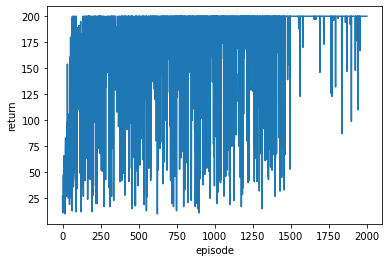

In [7]:
show_cartpole(optim_policy,max_list,min_list,division,step_num)

plt.xlabel('episode')
plt.ylabel('return')
plt.plot(optim_rewards)

<span style="font-size: 120%;"> エピソードは多分，その都度状態とその状態時における方策によって決定されると思う．したがって，方策は[1296,2]のサイズが正しく，得られた状態はその場で離散化できるようにしなければいけないと考えられる．
状態を得る→離散化→その時の方策→行動→終点まで繰り返す→行動価値→方策改善→...の流れだと思う．
したがって，エピソードを予め作る必要はなく，その都度つくりその都度cartpoleの関数に行動として入力する．
</span>

# まとめ

<span style="font-size: 120%;"> アルゴリズム的に正しく評価できているかわからない(自信がない)が，とりあえず棒を倒さないようにすることはできた．詳細は本を読んで確認しよう! </span>

# Q&A

Q1, なんで方策$\pi$の更新に状態価値関数じゃなくて行動価値関数を使うの? </span>  

~~A1,正確には分からないが，今回のcartpoleの問題を考えると，重要なのは状態ではなくて行動ということがわかる．例えば，ポールの傾きが～，角速度が～，...の時の状態は〇〇ということよりも，土台を右にずらした時〇〇，左にずらした時〇〇ということが分かった方が制御がしやすいし考えやすくもある．また，何を更新すればよいかということも分かりやすい．状態だと，傾きを最適にしたいの?角速度を最適にしたいの?ってなる．今まではgrid worldを相手に考えていたので，行動よりも状態を重視しているところがあった．したがって，どのような問題かによって，状態価値関数と行動価値関数を使い分ける必要がある．~~  
~~※ 遷移確率が使えないからという説明記事があったが，状態価値も行動価値も遷移確率を使わざる負えないので(式的に)，やはり問題によって使い分けるが適切だと考えている．モンテカルロ法は，遷移確率の代わりにサンプリングを用いている．多分...~~  

A1, [最適方策](https://qiita.com/triwave33/items/59768d14da38f50fb76c)にある通り，方策を改善するということは，状態価値がよりよくなるための<span style="color: red; ">行動$a$を選択する</span>ということ，つまり報酬が最大となるような行動$a$を選択すればよいということが分かる．そのためには，どの行動$a$を選択した場合に最も報酬が貰えるかを導出する必要がある．これは式で表すと，  

$$
\begin{eqnarray}
    \pi^{*}(s,a) &=& \mathrm{argmax}_{a} \Sigma_{s'}P^{a}_{ss'}[R^{a}_{ss'}+\gamma \mathrm{V^{\pi}}(s')]， \\
                 &=& \mathrm{argmax}_{a} \mathrm{Q^{\pi}}(s,a)
\end{eqnarray}
$$
 
となり，最も行動価値が大きくなる行動$a$を選択すればよいことがわかる．動的計画法(Dynamic Programming)では，このQ関数を計算により算出していたが，モンテカルロ法ではQ関数をサンプリングにより導出する．正しくは，$P^{a}_{ss'}$をサンプリングにより補う．Q関数の式はモンテカルロ法でも使うからね!  

<img src="figure/policy_improvement.jpg" width="500">

# 参考資料

- [今さら聞けない強化学習(8): モンテカルロ法でOpenAI GymのCartpoleを学習](https://qiita.com/triwave33/items/1b9c87089b2fce0dd481)
- [今さら聞けない強化学習（6）：反復法による最適方策](https://qiita.com/triwave33/items/59768d14da38f50fb76c)
- [ε-greedy行動選択](https://www.tcom242242.net/entry/2017/01/15/163250/)
- [強化学習について学んでみた。（その7）](https://yamaimo.hatenablog.jp/entry/2015/08/23/200000)
- [Introducing CartPole-v1](https://subscription.packtpub.com/book/data/9781789345803/6/ch06lvl1sec47/introducing-cartpole-v1)
- [OpenAI Gym](https://gym.openai.com/envs/#classic_control)
- [第10回　CartPole課題をQ学習で制御する](https://book.mynavi.jp/manatee/detail/id=88997)
- [【強化学習初心者向け】シンプルな実装例で学ぶSARSA法およびモンテカルロ法【CartPoleで棒立て：1ファイルで完結】](https://qiita.com/sugulu/items/7a14117bbd3d926eb1f2#%E3%83%A2%E3%83%B3%E3%83%86%E3%82%AB%E3%83%AB%E3%83%AD%E6%B3%95%E3%81%AB%E3%82%88%E3%82%8B%E5%BC%B7%E5%8C%96%E5%AD%A6%E7%BF%92)
- [強化学習について学んでみた。（その14）](https://yamaimo.hatenablog.jp/entry/2015/09/30/200000)
- [【強化学習】まとめてみた　第五回（１）（Q学習だけじゃない！モンテカルロ法）【ブラックジャック攻略】](https://qiita.com/MENDY/items/4a896b9800775ad987a7)